In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
formus = pd.read_csv(r'C:\Users\ximef\Documents\GitHub\TFM_KSCHOOL\Alejandro\Modelos\Modelos datos caracteristicas\formulario_combinaciones.json.csv')

In [2]:
formus.columns

Index(['Cuantas horas juega a la semana', 'Indique su peso',
       'Indique su altura', 'Rango de precio dispuesto a pagar',
       'Indique su lado de juego', 'Indique su nivel de juego',
       'Tipo de juego', 'Que tipo de balance te gusta',
       'Has tenido alguna de las siguientes lesiones previamente lumbares, epicondilitis, gemelos, fascitis, cervicales u hombros',
       'Con que frecuencia', 'Hace cuanto'],
      dtype='object')

In [3]:
# Diccionario para mapear para respuesta a un valor numérico
answer_mapping = {
    "Cuantas horas juega a la semana": {
        1: 'Menos de 3,5 horas',  #
        2: 'Mas de 3.5 horas'     
    },
    "Indique su peso": {
        1: 'Entre 51 y 70 Kg',    
        2: 'Entre 71 y 90 Kg',    
        3: 'Más de 91 Kg'         
    },
    "Indique su nivel de juego":{
        1: "Iniciacion",
        2: "Intermedio",
        3: "Avanzado"
    },
    "Tipo de juego":{
        1: "Defensivo",
        2:"Ofensivo"
    },
    "Indique su altura": {
        1: 'Entre 1,51 y 1,70 metros',  
        2: 'Entre 1,71 y 1,80 metros',  
        3: 'Mas de 1,80 metros'         
    },
    "Rango de precio dispuesto a pagar": {
        1: 'Menos de 100',     
        2: 'Entre 100 y 200',  
        3: 'Mas de 200'        
    },
    "Indique su lado de juego": {
        1: 'Drive',  
        1: 'Reves'  
    },
    "Que tipo de balance te gusta": {
        1: 'Medio',  
        2: 'Alto'   
    },
    "Has tenido alguna de las siguientes lesiones previamente lumbares, epicondilitis, gemelos, fascitis, cervicales u hombros": {
        4: 'Lumbares',                # scores basados en la probabilidad de la lesión
        5: 'Epicondilitis',           
        2: 'Gemelos o fascitis',      
        1: 'Cervicales',              
        3: 'Hombros',                 
        0: 'Ninguna'                  
    },
    "Con que frecuencia": {
        4: 'Siempre que juego defensivamente', 
        3: 'Siempre que juego ofensivamente',   
        2: 'Casi siempre que juego intensamente', 
        1: 'Rara vez cuando juego'              
    },
    "Hace cuanto": {
        3: 'Menos de 3 meses',   
        2: 'Entre 3 y 6 meses', 
        1: 'Mas de 6 meses'    
    }
}

In [4]:
# función para mapear respuestas a un valor basado en el diccionario
def map_answers_to_values(row,column,mapping_dic):
    response = row[column]
# aquí se consigue asignar el número correspondiente
    for key, value in mapping_dic[column].items():
        if response == value:
            return key
    return None
#aplicamos el mapping a las columnas nuevas (las numéricas)
for column in answer_mapping.keys():
    formus[column + '_numerical'] = formus.apply(map_answers_to_values, axis=1, column=column, mapping_dic = answer_mapping)

print(formus.head(2))

  Cuantas horas juega a la semana   Indique su peso         Indique su altura  \
0              Menos de 3,5 horas  Entre 51 y 70 Kg  Entre 1,51 y 1,70 metros   
1              Menos de 3,5 horas  Entre 51 y 70 Kg  Entre 1,51 y 1,70 metros   

  Rango de precio dispuesto a pagar Indique su lado de juego  \
0                      Menos de 100                    Drive   
1                      Menos de 100                    Drive   

  Indique su nivel de juego Tipo de juego Que tipo de balance te gusta  \
0                Iniciacion      Ofensivo                        Medio   
1                Iniciacion      Ofensivo                        Medio   

  Has tenido alguna de las siguientes lesiones previamente lumbares, epicondilitis, gemelos, fascitis, cervicales u hombros  \
0                                           Lumbares                                                                          
1                                           Lumbares                                  

In [5]:
numerical_columns = [col for col in formus.columns if col.endswith('_numerical')]

# Display solo las númericas para ver si ha funcionado
print(formus[numerical_columns].head())

   Cuantas horas juega a la semana_numerical  Indique su peso_numerical  \
0                                          1                          1   
1                                          1                          1   
2                                          1                          1   
3                                          1                          1   
4                                          1                          1   

   Indique su nivel de juego_numerical  Tipo de juego_numerical  \
0                                    1                        2   
1                                    1                        2   
2                                    1                        2   
3                                    1                        2   
4                                    1                        2   

   Indique su altura_numerical  Rango de precio dispuesto a pagar_numerical  \
0                            1                                     

In [6]:
print(formus[numerical_columns].shape)

(93312, 11)


In [7]:
# hacemos ponderaciones, dividiendo las preguntas para los dos score (lesion y nivel) y ganar así precisión
lesion_weights = {
    "Has tenido alguna de las siguientes lesiones previamente lumbares, epicondilitis, gemelos, fascitis, cervicales u hombros": 0.3,
    "Con que frecuencia": 0.2,
    "Hace cuanto": 0.2,
    "Indique su peso": 0.1,
    "Indique su altura": 0.05,
    "Tipo de juego": 0.1,
    "Que tipo de balance te gusta": 0.05,
}

# Weights for level-related questions
nivel_weights = {
    "Cuantas horas juega a la semana": 0.5,
    "Indique su nivel de juego" : 0.4,
    "Rango de precio dispuesto a pagar": 0.1,
    
}

In [8]:
def calculate_score(row,weights,answer_mapping):
    total_score = 0
    for column in weights.keys():
        if column in answer_mapping:
            answer_value = row[column + '_numerical']
            if answer_value is not None:
                total_score += answer_value * weights[column]

    return total_score
        

In [9]:
formus['lesion_score'] = formus.apply(calculate_score, axis=1, weights=lesion_weights, answer_mapping=answer_mapping)

In [10]:
formus['nivel_score'] = formus.apply(calculate_score, axis = 1, weights= nivel_weights, answer_mapping= answer_mapping)

In [11]:
print(formus[['lesion_score','nivel_score']].head())

   lesion_score  nivel_score
0           3.0          1.0
1           2.8          1.0
2           2.6          1.0
3           2.8          1.0
4           2.6          1.0


In [12]:
formus['lesion_score'].mean

<bound method Series.mean of 0        3.00
1        2.80
2        2.60
3        2.80
4        2.60
         ... 
93307    1.45
93308    1.25
93309    1.45
93310    1.25
93311    1.05
Name: lesion_score, Length: 93312, dtype: float64>

Text(0, 0.5, 'frequency')

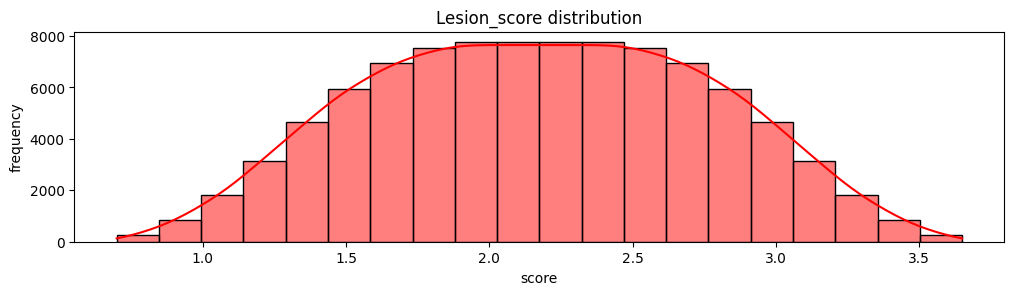

In [13]:
# vamos a visualizar los resultados !
plt.figure(figsize=(12,6))

plt.subplot(2,1,2)
sns.histplot(formus['lesion_score'],kde= True, color='red', bins=20)#kde is to visualize the distribution in a smooth way, continuous curve
plt.title('Lesion_score distribution')
plt.xlabel('score')
plt.ylabel('frequency')

Text(0, 0.5, 'frequency')

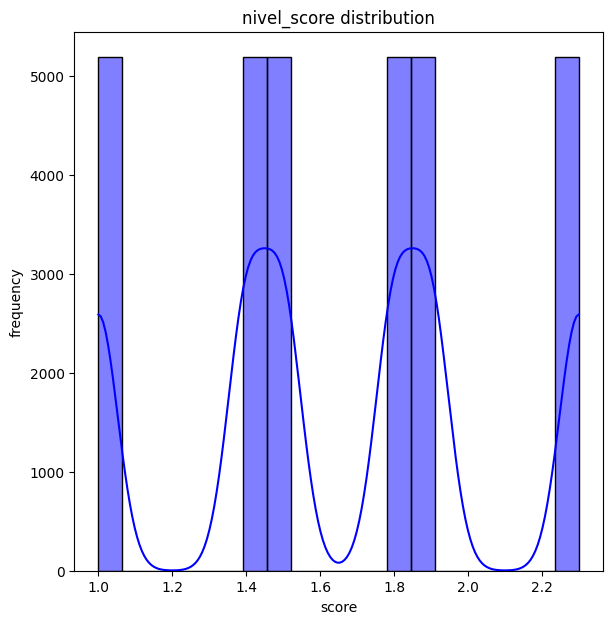

In [14]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
sns.histplot(formus['nivel_score'],kde= True, color='blue', bins=20)#kde is to visualize the distribution in a smooth way, continuous curve
plt.title('nivel_score distribution')
plt.xlabel('score')
plt.ylabel('frequency')

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scores = formus[['lesion_score','nivel_score']]

scores = formus[['lesion_score','nivel_score']] = scaler.fit_transform(scores)
print(formus[['lesion_score','nivel_score']].head())

   lesion_score  nivel_score
0      0.779661          0.0
1      0.711864          0.0
2      0.644068          0.0
3      0.711864          0.0
4      0.644068          0.0


Text(0, 0.5, 'frequency')

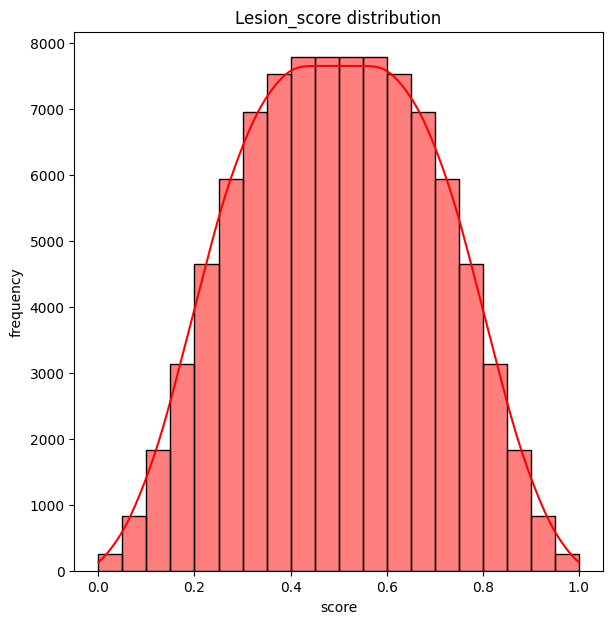

In [16]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
sns.histplot(formus['lesion_score'],kde= True, color='red', bins=20)#kde is to visualize the distribution in a smooth way, continuous curve
plt.title('Lesion_score distribution')
plt.xlabel('score')
plt.ylabel('frequency')

Text(0, 0.5, 'frequency')

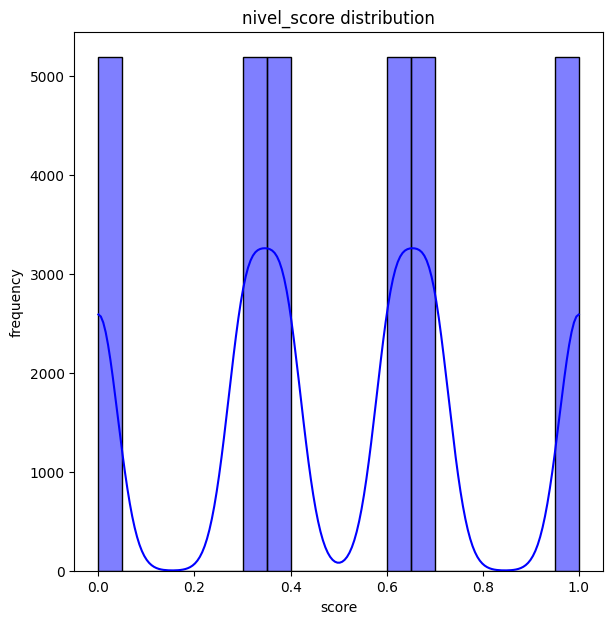

In [17]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
sns.histplot(formus['nivel_score'],kde= True, color='blue', bins=20)#kde is to visualize the distribution in a smooth way, continuous curve
plt.title('nivel_score distribution')
plt.xlabel('score')
plt.ylabel('frequency')